# Using ZEMAX and PyZDDE with IPython/Jupyter notebook

<img src="https://raw.githubusercontent.com/indranilsinharoy/PyZDDE/master/Doc/Images/articleBanner_00_usingZemax.png" height="230">

*Please feel free to [e-mail](mailto:indranil_leo@yahoo.com) any corrections, comments and suggestions to the author ([Indranil Sinharoy](http://indranilsinharoy.com/))*  

Last updated: 12/27/2015

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/)

**Summary:**

This notebook demonstrates how to use Zemax with PyZDDE within a Jupyter notebook. It shows how to create a PyZDDE object for communicating with Zemax. It shows some of the PyZDDE functions that are especially designed for using in the notebook environment (functions with prefix "ipz" instead of just "z"). It also shows how to create two simultaneous communication links to two instances of Zemax.



Using the [IPython notebook](http://ipython.org/notebook.html) with ZEMAX is attractive for the following reasons:

*  The notebook provides an interactive, exploratory computational environment similar to Mathematica's CDF where we can combine text, figures, computation, etc. within a single document. Personally, it really helps me to tinker and explore various stages of designs and optical simulations. 
*  It can provide a way for quick documentation of a lens design process as one progress through the design, including embedding intermittent figures, prescription files, thought process, etc.
*  It can also be used in an educational setting, such as to create and distribute lectures, notes, etc.

Before using the notebook for communicating with ZEMAX, ensure that ZEMAX is running. Once verified, a pyzdde object can be created and initialized as shown below.  

In [2]:
# imports
from __future__ import division
import os
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz
%matplotlib inline

## Create PyZDDE object 

In [3]:
l1 = pyz.createLink() # create a DDE link object for communication

Load an existing lens design file (Cooke 40 degree field) into Zemax's DDE server

In [4]:
zfile = os.path.join(l1.zGetPath()[1], 'Sequential', 'Objectives', 'Cooke 40 degree field.zmx')

In [5]:
l1.zLoadFile(zfile)

0

The following figure is the 2-D Layout plot of the lens.

In [6]:
# Surfaces in the sequential lens data editor
l1.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ STANDARD       Infinity       Infinity                                  0              0
   1 STANDARD       22.01359       3.258956                 SK16            19              0
   2 STANDARD      -435.7604       6.007551                                 19              0
   3 STANDARD      -22.21328      0.9999746                   F2            10              0
 STO STANDARD       20.29192       4.750409                                 10              0
   5 STANDARD        79.6836       2.952076                 SK16            15              0
   6 STANDARD      -18.39533       42.20778                                 15              0
 IMA STANDARD       Infinity                                          36.34532              0


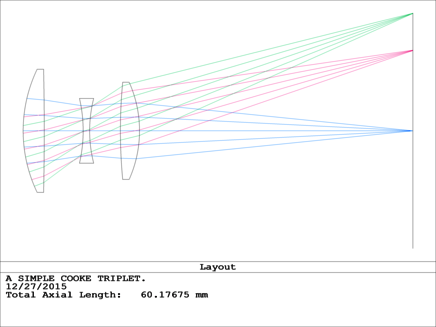

In [7]:
# note that ipzCaptureWindow() doesn't work in the new OpticStudio because 
# the dataitem 'GetMetafile' has become obsolete
l1.ipzCaptureWindow('Lay')

In [8]:
# General System properties
l1.zGetSystem()

systemData(numSurf=7, unitCode=0, stopSurf=4, nonAxialFlag=0, rayAimingType=0, adjustIndex=0, temp=20.0, pressure=1, globalRefSurf=1)

Few DDE *dataitems* that return information about the system have duplicate functions with the prefix `ipz`. They generally produce outputs that are suitable for interactive environments, and more suitable for human understanding. One example of such function pair is `zGetFirst()` and `ipzGetFirst()`: 

In [9]:
# Paraxial/ first order properties of the system
l1.zGetFirst()

firstOrderData(EFL=49.9999995, paraWorkFNum=4.99999995, realWorkFNum=4.978219667, paraImgHeight=18.19851153, paraMag=0.0)

In [10]:
# duplicate of zGetFirst() for use in the notebook
l1.ipzGetFirst()

Paraxial magnification : 0.0
Real working F/#       : 4.978219667
Effective focal length : 49.9999995
Paraxial working F/#   : 4.99999995
Paraxial image height  : 18.19851153


In [11]:
# ... another example is the zGetSystemAper() that returns information about the aperture. 
# The aperture type is retuned as a code which we might not remember always ...
l1.zGetSystemAper()

systemAper(apertureType=0, stopSurf=4, value=10.0)

In [12]:
# ...with the duplicate, ipzGetSystemAper(), we can immediately know that
# the aperture type is the Entrance Pupil Diameter (EPD)
l1.ipzGetSystemAper()

Aperture Type           : EPD
Value (system aperture) : 10.0
Stop surface            : 4


In [13]:
# information about the field definition
l1.ipzGetFieldData()

Field Normalization : Radial
Type                : Angles in degrees
Number of Fields    : 3
Max Y               : 20.0
Max X               : 20.0
   X       Y     Weight   VDX     VDY     VCX     VCY     VAN   
 0.00    0.00   1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
 0.00    14.00  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
 0.00    20.00  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  


### Analysis plots - ray-fan analysis plot as an example

To plot the ray-fan analysis graph using `ipzCaptureWindow()` function, we need to provide the 3-letter button code of the corresponding analysis function. If we don't remember the exact button code, we can use a helper function in `pyzdde` to get some help:

In [14]:
pyz.findZButtonCode('ray')

[Ray] Ray Fan

[Rdb] Ray Database

[Rtc] Ray Trace Control

[Rtr] Ray Trace

[Pol] Pol. Ray Trace

Found 5 Button codes

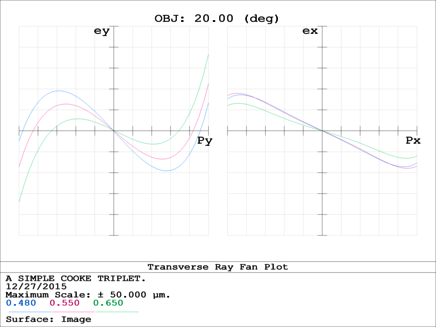

In [15]:
l1.ipzCaptureWindow('Ray', gamma=0.4)

Note that there are few other options for retrieving and plotting analysis plots from Zemax. They are discussed in a separate notebook. However, here is one worth quickly mentioning. You can ask `ipzCaptureWindow()` to just return the image pixel array instead of directly plotting. Then you can use matplotlib (or any other plotting libraries) to plotting. Here is an example:

In [19]:
lay_arr = l1.ipzCaptureWindow('Lay', percent=15, gamma=0.08, retArr=True)

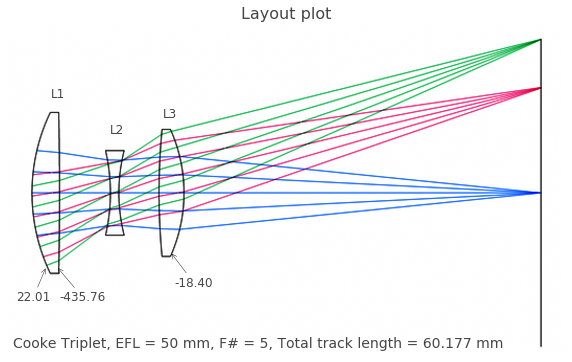

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pyz.imshow(lay_arr, cropBorderPixels=(5, 5, 1, 90), fig=fig, faxes=ax)
ax.set_title('Layout plot', fontsize=16)
# Annotate Lens numbers
ax.text(41, 70, "L1", fontsize=12)
ax.text(98, 105, "L2", fontsize=12)
ax.text(149, 89, "L3", fontsize=12) 
# Annotate the lens with radius of curvature information
col = (0.08,0.08,0.08)
s1_r = 1.0/l1.zGetSurfaceData(1,2)
ax.annotate("{:0.2f}".format(s1_r), (37, 232), (8, 265), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
s2_r = 1.0/l1.zGetSurfaceData(2,2)
ax.annotate("{:0.2f}".format(s2_r), (47, 232), (50, 265), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
s6_r = 1.0/l1.zGetSurfaceData(6,2)
ax.annotate("{:0.2f}".format(s6_r), (156, 218), (160, 251), fontsize=12, 
                arrowprops=dict(arrowstyle="->", linewidth=0.45, color=col,  relpos=(0.5,0.5)))
ax.text(5, 310, "Cooke Triplet, EFL = {} mm, F# = {}, Total track length = {} mm"
        .format(50, 5, 60.177), fontsize=14) 
plt.show()

Now, lets say that we want to find the angular magnification of the above optics and we want to find if Zemax provides any operand whose value we can directly read. For that we can use another module level helper function to find all operands related to angular magnification:

In [21]:
pyz.findZOperand('angular magnification')

[AMAG] Angular magnification, defined as the ratio of the paraxial image space chief ray angle to the paraxial object space chief ray angle.

Found 1 Optimization operands

Bingo! `AMAG` is the operand we want. Now we can use

In [22]:
l1.zOperandValue('AMAG', 1) # the argument "1" is for the wavelength

0.977161033

Of course, there is a function in PyZDDE called `zGetPupilMagnification()` that we can use to get the angular magnification since the inverse of the pupil magnificaiton is the angular magnification (as a consequence of the Lagrange Optical Invariant).

In [23]:
1.0/l1.zGetPupilMagnification()

0.9771610225774343

## Connecting to another Zemax session simultaneously

Now, a second `pyzdde` object is created to communicate with a second ZEMAX server. Note that the first object is still present.

In [9]:
l2 = pyz.createLink() # create a second DDE communication link object

Set up lens surfaces in the second ZEMAX DDE server. Towards the end, `zPushLens()` is called so that the LDE is updated with the just-made lens.

In [10]:
# Erase all lens data in the LDE (good practice)
l2.zNewLens()

# Wavelength data
wavelengths = (0.48613270, 0.58756180, 0.65627250) #mm
weights = (1.0, 1.0, 1.0)

l2.zSetWaveTuple((wavelengths, weights))
l2.zSetPrimaryWave(2) # Set 0.58756180 as primary

# System aperture data, and global reference surface.
aType, stopSurf, appValue = 0, 1, 100 # EPD,STO is 1st sur, value = 100

l2.zSetSystemAper(aType, stopSurf, appValue)

# General data (we need set whatever is really required ... the following
# is just shown as an example)
unitCode, rayAimingType, globalRefSurf = 0, 0, 1  # mm, off,ref=1st surf
useEnvData, temp, pressure = 0, 20, 1             # off, 20C, 1ATM

setSystemArg = (unitCode, stopSurf, rayAimingType,
                useEnvData, temp, pressure, globalRefSurf)
l2.zSetSystem(*setSystemArg)

# Setup Field data
l2.zSetField(0, 0, 3, 1)                       # number of fields = 3 
l2.zSetField(1, 0, 0)                          # 1st field, on-axis x, on-axis y, weight = 1 (default)
l2.zSetField(3, 0, 10, 1.0, 0.0, 0.0, 0.0)     # 2nd field
l2.zSetField(2,0,5,2.0,0.5,0.5,0.5,0.5, 0.5)   # 3rd field

#Setup the system, wavelength, (but not the field points)
l2.zInsertSurface(2)
l2.zInsertSurface(3)

#Set surface data, note that by default, all surfaces are Standard type
# OBJ: Surface 0
l2.zSetSurfaceData(0,3,500.00)   #OBJ thickness = 0.5 m or 500 mm
#STO: Surface 1
l2.zSetSurfaceData(1,2,0)        #STO Radius = Infinity
l2.zSetSurfaceData(1,3,20.00)    #STO Thickness = 20 mm
l2.zSetSurfaceData(1,5,50.00)    #STO Semi-diameter = 50 mm
#Surface 2
l2.zSetSurfaceData(2,2,1/150)    #Surf2 Radius = 150 mm
l2.zSetSurfaceData(2,3,100.0)    #Surf2 Thickness = 100 mm
l2.zSetSurfaceData(2,4,'BK7')    #Surf2 Glass, type = BK7
l2.zSetSurfaceData(2,5,65.00)    #Surf2 Semi-diameter = 65.00 mm
#Surface 3
l2.zSetSurfaceData(3,2,-1/600)   #Surf3 Radius = -600 mm
l2.zSetSurfaceData(3,3,300.00)   #Surf3 Thickness = 184 mm
l2.zSetSurfaceData(3,5,65.00)    #Surf3 Semi-diameter = 65.00 mm

# Perform Quick Focus
l2.zQuickFocus(3,1)

# push lens
l2.zPushLens(update=1)

0

Layout plot of the second lens

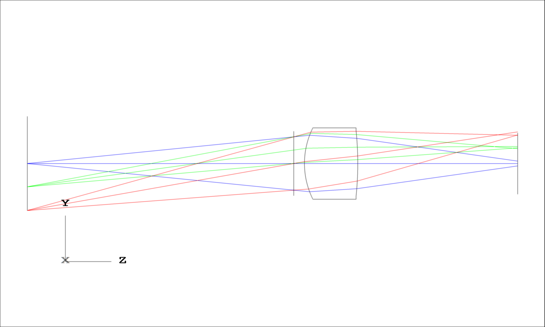

In [11]:
l2.ipzCaptureWindow('L3d')

Spot diagram of the second lens

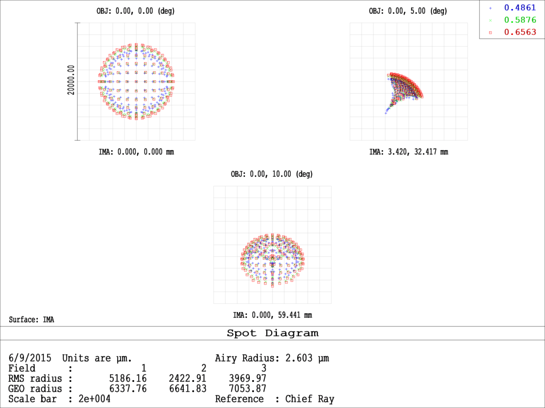

In [18]:
l2.ipzCaptureWindow('Spt', percent=15, gamma=0.55)

Just to demonstrate that the first lens (in the first ZEMAX server) is still available, the Layout plot is rendered again.

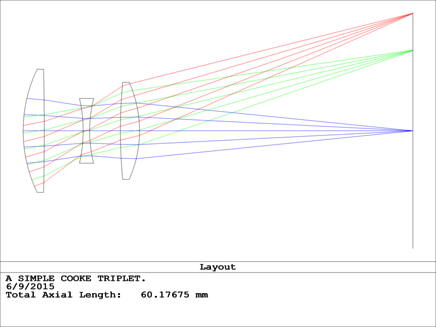

In [15]:
l1.ipzCaptureWindow('Lay')

Spot diagram of the first lens

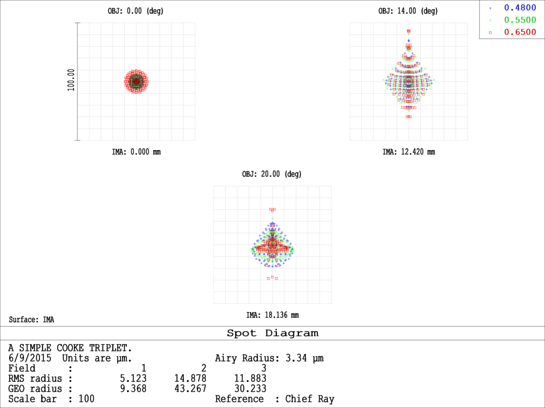

In [17]:
l1.ipzCaptureWindow('Spt', percent=15, gamma=0.55)

MTF plot of the first lens

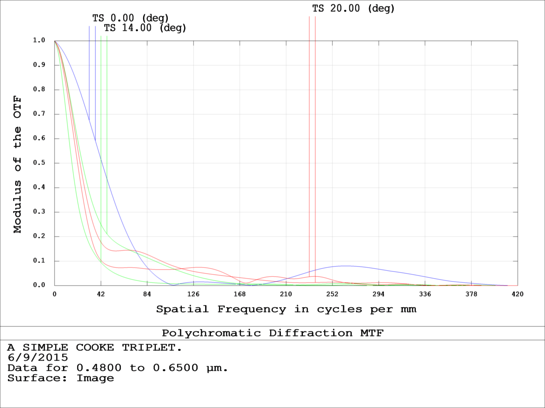

In [19]:
l1.ipzCaptureWindow('Mtf', percent=15, gamma=0.5)

## Executing ZPL macro

Lastly, here is an example of how execute a ZPL macro using the PyZDDE. 

Since ZEMAX can execute ZPL macros present in a set folder (generally the default macro folder in the data folder), the appropriate macro folder path needs to be set if it is not the default macro folder path.

In [20]:
l1.zSetMacroPath(r"C:\PROGRAMSANDEXPERIMENTS\ZEMAX\Macros")

0

The following command executes the ZPL macro 'GLOBAL' provided by ZEMAX. The macro computes the global vertex coordinates or orientations surface by surface by surface, and outputs a text window within the ZEMAX environment. Maximize (if required) the ZEMAX application window to see the output after executing the following command.

In [21]:
l1.zExecuteZPLMacro('GLO')

0

Close the DDE links

In [16]:
pyz.closeLink() # Also, l1.close(); l2.close()